https://www.kaggle.com/arjunbhasin2013/ccdata

Link to Datasorce

CLUSTERING ALGORITHMS IN PYSPARK    

In [1]:
# import Libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import Imputer, VectorAssembler, Normalizer, CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.ml.clustering import BisectingKMeans, KMeans, LDAModel, LDA
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.linalg import Vectors, Vector

import re
import pandas as pd 
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv('credit_card.csv', inferSchema=False, header=True)

df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: string (nullable = true)
 |-- BALANCE_FREQUENCY: string (nullable = true)
 |-- PURCHASES: string (nullable = true)
 |-- ONEOFF_PURCHASES: string (nullable = true)
 |-- INSTALLMENTS_PURCHASES: string (nullable = true)
 |-- CASH_ADVANCE: string (nullable = true)
 |-- PURCHASES_FREQUENCY: string (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: string (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: string (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: string (nullable = true)
 |-- CASH_ADVANCE_TRX: string (nullable = true)
 |-- PURCHASES_TRX: string (nullable = true)
 |-- CREDIT_LIMIT: string (nullable = true)
 |-- PAYMENTS: string (nullable = true)
 |-- MINIMUM_PAYMENTS: string (nullable = true)
 |-- PRC_FULL_PAYMENT: string (nullable = true)
 |-- TENURE: string (nullable = true)



In [3]:
# casting multiple types
float_vars = list(set(df.columns) - set(['CUST_ID']))
for column in float_vars:
    df = df.withColumn(column, df[column].cast(FloatType()))

# imputing Data
input_cols = list(set(df.columns) - set(['CUST_ID']))
imputer = Imputer(inputCols=input_cols, outputCols=["{}_imputed".format(c) for c in input_cols])
df_imputed = imputer.fit(df).transform(df)
df_imputed = df_imputed.drop(*input_cols)
new_column_names = list(map(lambda x: x.replace("_imputed", ""), df.columns))

df_imputed = df_imputed.toDF(*new_column_names)

In [4]:
# data preparation Pipeline
ignore = ['CUST_ID']
assembler = VectorAssembler(inputCols=[x for x in df.columns if x not in ignore], outputCol='features')
normalizer = Normalizer(inputCol='features', outputCol='normFeatures', p=1.0)
pipeline = Pipeline(stages=[assembler, normalizer])
transformations = pipeline.fit(df_imputed)
df_updated = transformations.transform(df_imputed)

# building the Model
bkm = BisectingKMeans().setK(2).setSeed(1)
model = bkm.fit(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))

# make predictions
pred = model.transform(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))

# initailize the Evaluator and compute the Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(pred)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# shows the result
print("Cluster centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)


Silhouette with squared euclidean distance = 0.49855848955650006
Cluster centers: 
[1.56899718e-02 1.07480745e-04 2.60570968e-02 9.19431713e-02
 4.12514135e-02 4.13338382e-02 4.21892243e-02 8.65430186e-05
 2.36687998e-03 1.49477386e-04 1.69572988e-03 6.73444143e-02
 6.69629544e-01 5.20146262e-05 2.03692023e-05 7.78368846e-05
 4.99429055e-06]
[9.87433798e-02 5.52450766e-05 4.51778189e-02 1.56153161e-01
 1.67613049e-01 3.68880540e-02 8.98395022e-02 4.07553710e-05
 1.58891509e-03 1.27041540e-04 1.35422759e-03 8.20154181e-02
 3.19911998e-01 1.37626105e-05 2.00523886e-05 4.36827025e-04
 2.07931012e-05]


 Silhouette coefficient can vary between -1 and 1. Values close to 1 define a clear 
separation and are more desirable.

Silhouette score = 0.49855848955650006
Silhouette score = 0.47032306895494647
Silhouette score = 0.36841230437497996
Silhouette score = 0.35979911858435865
Silhouette score = 0.3787940202378902
Silhouette score = 0.3639517765678912


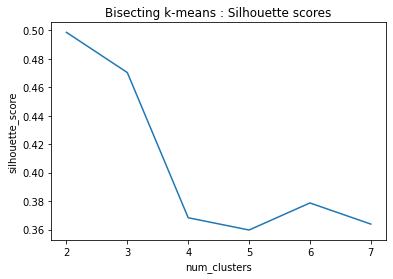

In [5]:
# calculate Silhouette coeff for diff no of clusters and plot
sil_coeff = []
num_clusters = []
for i in range(2, 8):
    bkm = BisectingKMeans().setK(i).setSeed(1)
    model = bkm.fit(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
    pred = model.transform(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(pred)
    sil_coeff.append(silhouette)
    num_clusters.append(i)
    print("Silhouette score = " + str(silhouette))

df_viz = pd.DataFrame(zip(num_clusters,sil_coeff), columns=['num_clusters','silhouette_score'])
sns.lineplot(x="num_clusters", y="silhouette_score", data=df_viz)
plt.title('Bisecting k-means : Silhouette scores')
plt.xticks(range(2, 8))
plt.show()
# as the no of clusters increases, the Sil coeff drops

K-Means() Clustering algorithm

Silhouette with squared euclidean distance = 0.49856764446169394
Cluster centers: 
[9.87267926e-02 5.52420719e-05 4.51923000e-02 1.56132502e-01
 1.67607737e-01 3.68861785e-02 8.98299971e-02 4.07539038e-05
 1.58877727e-03 1.27030958e-04 1.35435512e-03 8.20280322e-02
 3.19938943e-01 1.37602987e-05 2.00543992e-05 4.36753645e-04
 2.07896083e-05]
[1.56952070e-02 1.07504143e-04 2.60219527e-02 9.19627812e-02
 4.12198014e-02 4.13390469e-02 4.21922052e-02 8.65612107e-05
 2.36741330e-03 1.49505893e-04 1.69559052e-03 6.73144634e-02
 6.69692711e-01 5.20319817e-05 2.03653144e-05 7.78628562e-05
 4.99595698e-06]
Silhouette:  0.49856764446169394
Silhouette:  0.5085437493303202
Silhouette:  0.47936391094272945
Silhouette:  0.45546028029107755
Silhouette:  0.416434035739826
Silhouette:  0.4613063828101579


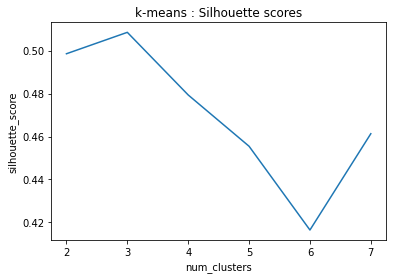

In [21]:
# training a K-means model
kmeans = KMeans().setK(2).setSeed(1003)
model = kmeans.fit(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))

pred = model.transform(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(pred)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# show the result
centers = model.clusterCenters()
print('Cluster centers: ')
for center in centers:
    print(center)

sil_coeff=[]
num_clusters=[]
for i in range(2,8):
    kmeans = KMeans().setK(i).setSeed(1003)
    model = kmeans.fit(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
    predictions = model.transform(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    sil_coeff.append(silhouette)
    num_clusters.append(i)
    print("Silhouette:  " + str(silhouette))

df_viz=pd.DataFrame(zip(num_clusters,sil_coeff), columns=['num_clusters','silhouette_score'])
sns.lineplot(x = "num_clusters", y = "silhouette_score", data=df_viz)
plt.title('k-means : Silhouette scores')
plt.xticks(range(2, 8))
plt.show()


Implement LDA with PySpark

https://www.kaggle.com/PromptCloudHQ/amazon-echo-dot-2-reviews-dataset

Link to Dataset

In [2]:
spark = SparkSession.builder.appName('LDA').getOrCreate()
df = spark.read.csv('amazon.csv', inferSchema=False, header=True)

df.printSchema()
# total number of records is 6855
# df.count()

root
 |-- Pageurl: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Review Color: string (nullable = true)
 |-- User Verified: string (nullable = true)
 |-- Review Date: string (nullable = true)
 |-- Review Useful Count: string (nullable = true)
 |-- Configuration Text: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Declaration Text: string (nullable = true)



In [3]:
# extract the REVIEW TEXT from the DF and preprocess
reviews = df.rdd.map(lambda x: x['Review Text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = reviews.map(
    lambda document: document.strip().lower()
).map(
    lambda document: re.split(" ", document)
).map(
    lambda word: [x for x in word if x.isalpha()]
).map(
    lambda word: [x for x in word if len(x) > 3]
).map(
    lambda word: [x for x in word if x not in StopWords]
).zipWithIndex()


In [ ]:
# create a DF with the TOKENS
df_txts = spark.createDataFrame(tokens, ['list_of_words', 'index'])

# TF
cv= CountVectorizer(inputCol='list_of_words', outputCol='raw_features', vocabSize=5000, minDF=10)
cvModel = cv.fit(df_txts)
result_cv = cvModel.transform(df_txts)

# IDF
idf = IDF(inputCol='raw_features', outputCol='features')
idfModel = idf.fit(result_cv)
result_all = idfModel.transform(result_cv)
# Stop
